# Developing an Image Classifier Application

This project aims to train an image classifier to recognize different species of flowers, then build a command line application to train the model and predict any dataset of labled images. 

The dataset has 102 flower species: [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html). You can download this dataset to work on your local machine. However the training step requires Cuda GPU for faster processing time

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content


## Step 1: Load, process, transform data

In [1]:
#Imports library needed
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import json
import os
cwd = os.getcwd()

In [31]:
#Show processed image
def imshow(image,ax=None, title = None, normalize = True):
    #Image show for Tensor."
    print('image shape before transpose',image.shape)
    if ax is None:
        fig, ax = plt.subplots()
        image = image.numpy().transpose((1,2,0))
    if normalize:
        mean = np.array([0.485,0.456,0.406]) #hard code the means that were used in the model
        std = np.array([0.229,0.224,0.225]) #hard code the standard deviation that were used in the model 
        image = std*image+mean #turn the normalized data into regular size
        print('image shape after transpose', image.shape)
        image = np.clip(image,0,1) #limit value of the array to 0, 1
    
    ax.imshow(image)
    return ax

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flower_data'
#train_dir = data_dir + '/train'
#valid_dir = data_dir + '/valid'
#test_dir = data_dir + '/test'

In [4]:
def process_data(data_dir):
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'
    test_dir = data_dir + '/test'
    train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],
                                                           [0.229,0.224,0.225])])
    valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],
                                                           [0.229,0.224,0.225])])
    test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],
                                                           [0.229,0.224,0.225])])
    train_datasets = datasets.ImageFolder(train_dir,transform = train_transforms)
    valid_datasets = datasets.ImageFolder(valid_dir,transform = valid_transforms)
    test_datasets = datasets.ImageFolder(test_dir, transform = test_transforms)
    
    trainloader = torch.utils.data.DataLoader(train_datasets,batch_size = 32, shuffle = True)
    validloader = torch.utils.data.DataLoader(valid_datasets,batch_size = 32, shuffle = True)
    testloader = torch.utils.data.DataLoader(test_datasets,batch_size = 32, shuffle = True)
    
    return (train_datasets, trainloader, validloader, testloader)

In [5]:
train_datasets, trainloader, validloader,testloader = process_data(data_dir)
print('Number of batches in train set:', len(trainloader))
print('Number of batches in validation set:',len(validloader))
print('Number of batches in test set:',len(testloader))

Number of batches in train set: 205
Number of batches in validation set: 26
Number of batches in test set: 26


Below codes help visualize about 4 images in the train, validation and test dataset using <b>imshow function</b> defined above. Each image will have size of 224x224 as defined in the tranforms steps and 3 color channels (for RGB color images)     

image shape before transpose torch.Size([3, 224, 224])
image shape after transpose (224, 224, 3)


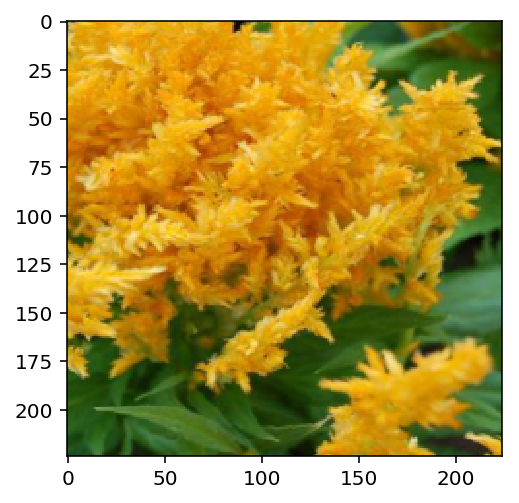

In [32]:
# test the loader and show the image
data_iter = iter(trainloader)
images, labels= next(data_iter)
for ii in range(1):
    imshow(images[ii], normalize=True)
    

image shape before transpose torch.Size([3, 224, 224])
image shape after transpose (224, 224, 3)


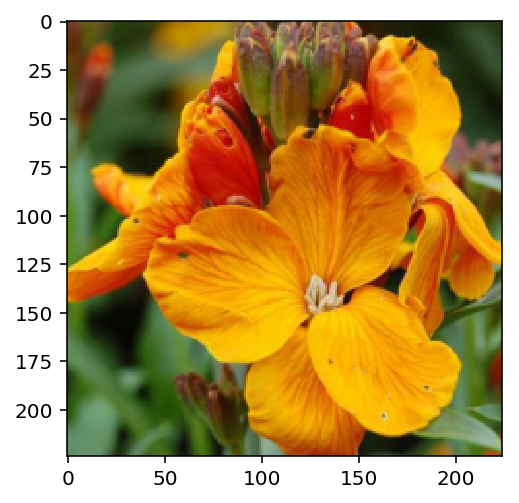

In [7]:
data_iter = iter(testloader)
images, labels= next(data_iter)
for ii in range(1):
    imshow(images[ii], normalize=True)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [8]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(len(cat_to_name))
print(cat_to_name)

102
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54'

There are 102 flowers class to be classified

## Step 2: Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

There are 4 steps involved in this Part:
* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) from torchvision.models
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

In [9]:

def build_model(arch='vgg16', hidden_units=4096, output_units=102):
    if arch == 'vgg16':
        model = models.vgg16(pretrained = True)
        input_units = 25088
        
    elif arch == 'vgg19':
        model = models.vgg19(pretrained = True)
        input_units = 25088
        
    elif arch == 'densenet121':
        model = models.densenet121(pretrained = True)
        input_units = 1024
        
    classifier = nn.Sequential(OrderedDict([
        ('fc1',nn.Linear(input_units,hidden_units)), 
        ('relu',nn.ReLU()),
        ('dropout',nn.Dropout(p=0.2)), #use dropout to avoid Overfitting
        ('fc2',nn.Linear(hidden_units,output_units)),
        ('output',nn.LogSoftmax(dim=1))
    ]))

    #Add the classifier to the pretrained model
    #choose 1 of the 3 models ('densenet121','vgg19','resnet18')
    for params in model.parameters():
            params.requires_grad = False
    model.classifier = classifier

    return model


In [10]:
arch='densenet121' 
hidden_units=520
output_units=102
model = build_model(arch=arch, hidden_units = hidden_units,output_units=output_units)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 88567730.39it/s]


Using cuda will speed up the training, but if your local machine cannot set up Cuda GPU then using cpu may also work with maybe 1 epoch and it will take a long time

In [11]:
#Train the network with pretrainded model, Loop through each epoch and show the running loss for training process
def train_model(model,learning_rate = 0.001, epochs =5, device='cuda'):
    
    device = torch.device("cuda" if torch.cuda.is_available() and device == 'cuda' else "cpu")
    
    model.to(device)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(),lr=learning_rate)
    epochs = epochs
    
    train_datasets,trainloader, validloader, testloader = process_data(data_dir)
    running_losses, running_valid_losses = [],[]
    for e in range(epochs):
        running_loss = 0
        corrects = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device) #Make sure that the training step is running on gpu

            #clean up accumulated gradients before training the new batch
            optimizer.zero_grad()

            #Forward and backward pass 
            log_ps = model.forward(images)
            loss = criterion(log_ps,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() #add loss of the batch to the running loss

        #use the validation datset to compare train and validation loss    
        else: 
            running_valid_loss = 0
            running_accuracy = 0
            with torch.no_grad():
                model.eval() #set model to evaluation mode to stop dropout 
                for images, labels in validloader:
                    images, labels = images.to(device), labels.to(device)           
                    log_ps = model.forward(images)
                    valid_loss = criterion(log_ps, labels)
                    running_valid_loss += valid_loss.item()

                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy = torch.mean(equals.type(torch.FloatTensor))
                    running_accuracy += accuracy.item()
                    
            model.train()

            print("Epoch:", e+1,
                  "Training loss:{:.3f}..".format(running_loss/len(trainloader)),
                  "Validation loss:{:.3f}..".format(running_valid_loss/len(validloader)),
                  #"Running Accuracy:{:.3f}..".format(running_accuracy),
                  "Validation accuracy:{:.3f}%..".format(running_accuracy*100/len(validloader)))

            running_losses.append(running_loss/len(trainloader))
            running_valid_losses.append(running_valid_loss/len(validloader))
            
    print('Train Losses:',running_losses,
         'Validation Losses:',running_valid_losses)

    return running_losses, running_valid_losses,model


In [12]:
data_dir = 'flower_data'
epoch = 5
running_losses, running_valid_losses,trained_model = train_model(model,learning_rate = 0.001,epochs=epoch, device='cuda')

Epoch: 1 Training loss:3.008.. Validation loss:1.278.. Validation accuracy:68.737%..
Epoch: 2 Training loss:1.295.. Validation loss:0.625.. Validation accuracy:84.442%..
Epoch: 3 Training loss:0.926.. Validation loss:0.449.. Validation accuracy:89.183%..
Epoch: 4 Training loss:0.756.. Validation loss:0.365.. Validation accuracy:90.171%..
Epoch: 5 Training loss:0.670.. Validation loss:0.363.. Validation accuracy:90.558%..
Train Losses: [3.0077675860102584, 1.2950204735848962, 0.9259522984667522, 0.7561596047587511, 0.6699992224937532] Validation Losses: [1.2775196845714862, 0.6247622726055292, 0.4486284874952756, 0.3650672541787991, 0.362628120642442]


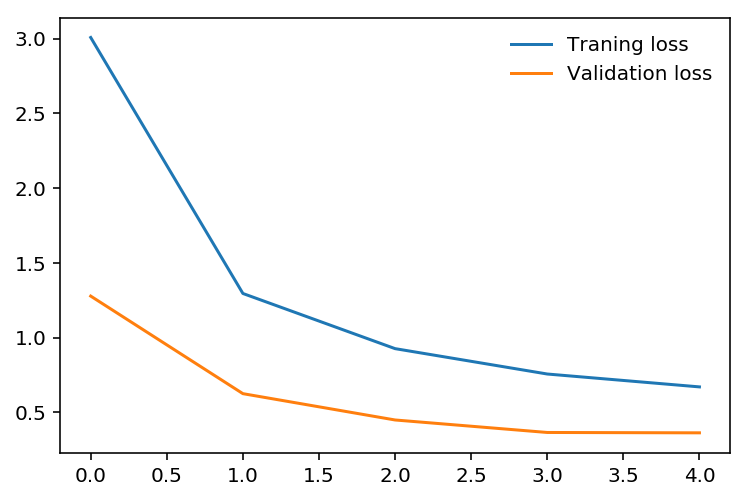

In [13]:
#visualize the train and test loss
plt.plot(running_losses, label = 'Traning loss')
plt.plot(running_valid_losses, label = 'Validation loss')
plt.legend(frameon=False)

The losses keep decreasing for both training and validation set, which is a good sign. The chart shows no overfitting problem as we have used dropout during the training process. Using Dropout in training and not in validation step might also be the cause for lower validation losses than training losses.

## Step 3: Testing the network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [14]:
# TODO: Do validation on the test set
def test_data(model, data_dir, device = 'cuda'):
    correct = 0
    total = 0
    step = 0
    model.to(device)
    train_datasets,trainloader, validloader, testloader = process_data(data_dir)
    with torch.no_grad(): #turn off gradient step to reduce computation time and use up resources
        model.eval()
        for images, labels in testloader:
            step += 1
            images, labels = images.to(device), labels.to(device)
            outputs = model.forward(images)
            ps = torch.exp(outputs) #convert to softmax probability from 0 to 1 for each image in each batch
            top_p,top_class = ps.topk(1,dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy = torch.mean(equals.type(torch.FloatTensor))
            print('Accuracy for batch',step,':{:.3f}%'.format(accuracy*100))

            correct += sum(equals).item()
            total+= labels.size(0)
    print('Number of correct classified images:',correct)
    print('Number of images in test set:', total)
    print('Accuracy of test set:{:.3f}%'.format(100*correct/total))


In [15]:
test_data(trained_model,data_dir,device = 'cuda')

Accuracy for batch 1 :93.750%
Accuracy for batch 2 :87.500%
Accuracy for batch 3 :93.750%
Accuracy for batch 4 :84.375%
Accuracy for batch 5 :84.375%
Accuracy for batch 6 :87.500%
Accuracy for batch 7 :100.000%
Accuracy for batch 8 :87.500%
Accuracy for batch 9 :87.500%
Accuracy for batch 10 :90.625%
Accuracy for batch 11 :75.000%
Accuracy for batch 12 :87.500%
Accuracy for batch 13 :78.125%
Accuracy for batch 14 :90.625%
Accuracy for batch 15 :87.500%
Accuracy for batch 16 :90.625%
Accuracy for batch 17 :90.625%
Accuracy for batch 18 :87.500%
Accuracy for batch 19 :100.000%
Accuracy for batch 20 :90.625%
Accuracy for batch 21 :90.625%
Accuracy for batch 22 :90.625%
Accuracy for batch 23 :93.750%
Accuracy for batch 24 :87.500%
Accuracy for batch 25 :90.625%
Accuracy for batch 26 :84.211%
Number of correct classified images: 729
Number of images in test set: 819
Accuracy of test set:89.011%


## Step 4: Save and load the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [17]:
# TODO: Save the checkpoint 
save_dir = os.getcwd()
checkpoint = save_dir +'/'+'final_checkpoint.pth'
trained_model.class_to_idx = train_datasets.class_to_idx
trained_model.to('cpu')
torch.save({'arch':arch,
                'hidden_units':hidden_units,
                'output_units':output_units,
                'state_dict': trained_model.state_dict(),
                'class_to_idx': trained_model.class_to_idx}, checkpoint)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [18]:
# TODO: Write a function that loads a checkpoint and rebuild the model

def load_checkpoint(checkpointfile):
    checkpoint = torch.load(checkpointfile)
    model = build_model(checkpoint['arch'], checkpoint['hidden_units'], checkpoint['output_units'])
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    return model

In [ ]:
save_dir = os.getcwd()
checkpoint = save_dir +'/'+'final_checkpoint.pth'
loaded_model = load_checkpoint(checkpoint)
loaded_model.eval()


## Step 5: Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

### Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [20]:
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array and a Tensor
    '''
    from PIL import Image
    image = Image.open(image_path)
    
    #resize image
    if image.size[0]> image.size[1]:
        image.thumbnail((100000,256))
    else:
        image.thumbnail((256,100000))
        
    w, h = image.size
    processed_im = image.crop(((w-224)/2,(h-224)/2,(w+224)/2,(h+224)/2))
    
    #convert to numpy array
    np_im = np.array(processed_im)
    
    #normalize
    np_im = (np_im-np.average(np_im))/np.std(np_im)
    np_im = np_im.transpose((2,0,1))
    tensor_im = torch.from_numpy(np_im).float()
    return tensor_im
    # TODO: Process a PIL image for use in a PyTorch model

In [21]:
#below function shows image using the image tensor input
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [22]:
import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)        

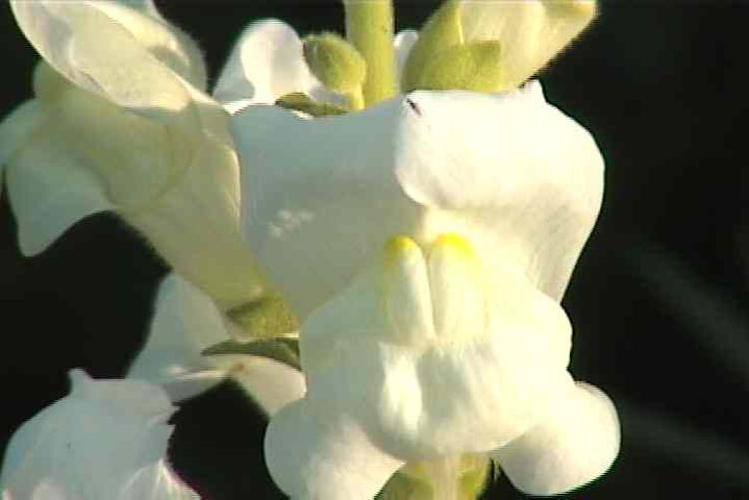

In [23]:
image_path = 'flowers/test/11/image_03098.jpg'
image = Image.open(image_path) #'flowers/train/2/image_05088.jpg'
image

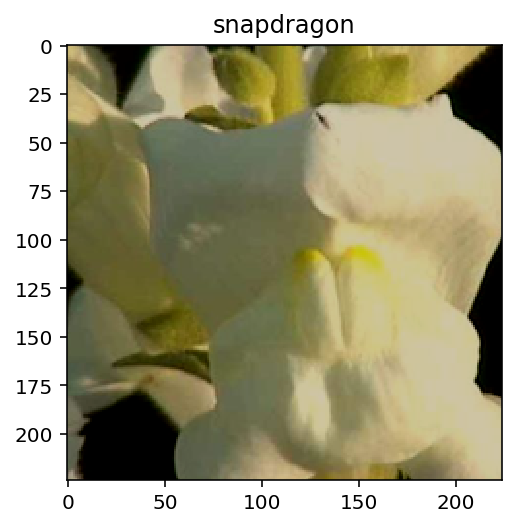

In [24]:
tensor_image = process_image(image_path)
img_label = cat_to_name[image_path.split('/')[-2]]
imshow(tensor_image, title= img_label)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [25]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    #process the image and show the image        
    tensor_img = process_image(image_path)

    #the model requires the batch size at the start of the input tensor, use unsqueeze to add a dimension of 1 (batch size=1)
    #to dimension 0 of image tensor
    tensor_img.unsqueeze_(0)
    log_results = model.forward(tensor_img)
    probs = torch.exp(log_results)
    top_p, top_class_idx = probs.topk(topk, dim = 1)
    
    #convert top_p, top_class tensor to numpy and then to list. 
    #Because the variable require Gradient, use var.detach().numpy() instead
    top_probs = top_p.detach().numpy().tolist()[0]
    top_class_idx = top_class_idx.detach().numpy().tolist()[0]
    
    #map the top_class to flower name using model.class_to_idx.items()
    idx_to_class = {val:key for key,val in model.class_to_idx.items()}
    top_class_label = [idx_to_class[label] for label in top_class_idx]
    top_flowers = [cat_to_name[label] for label in top_class_label]
    
    return top_probs, top_flowers
    

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


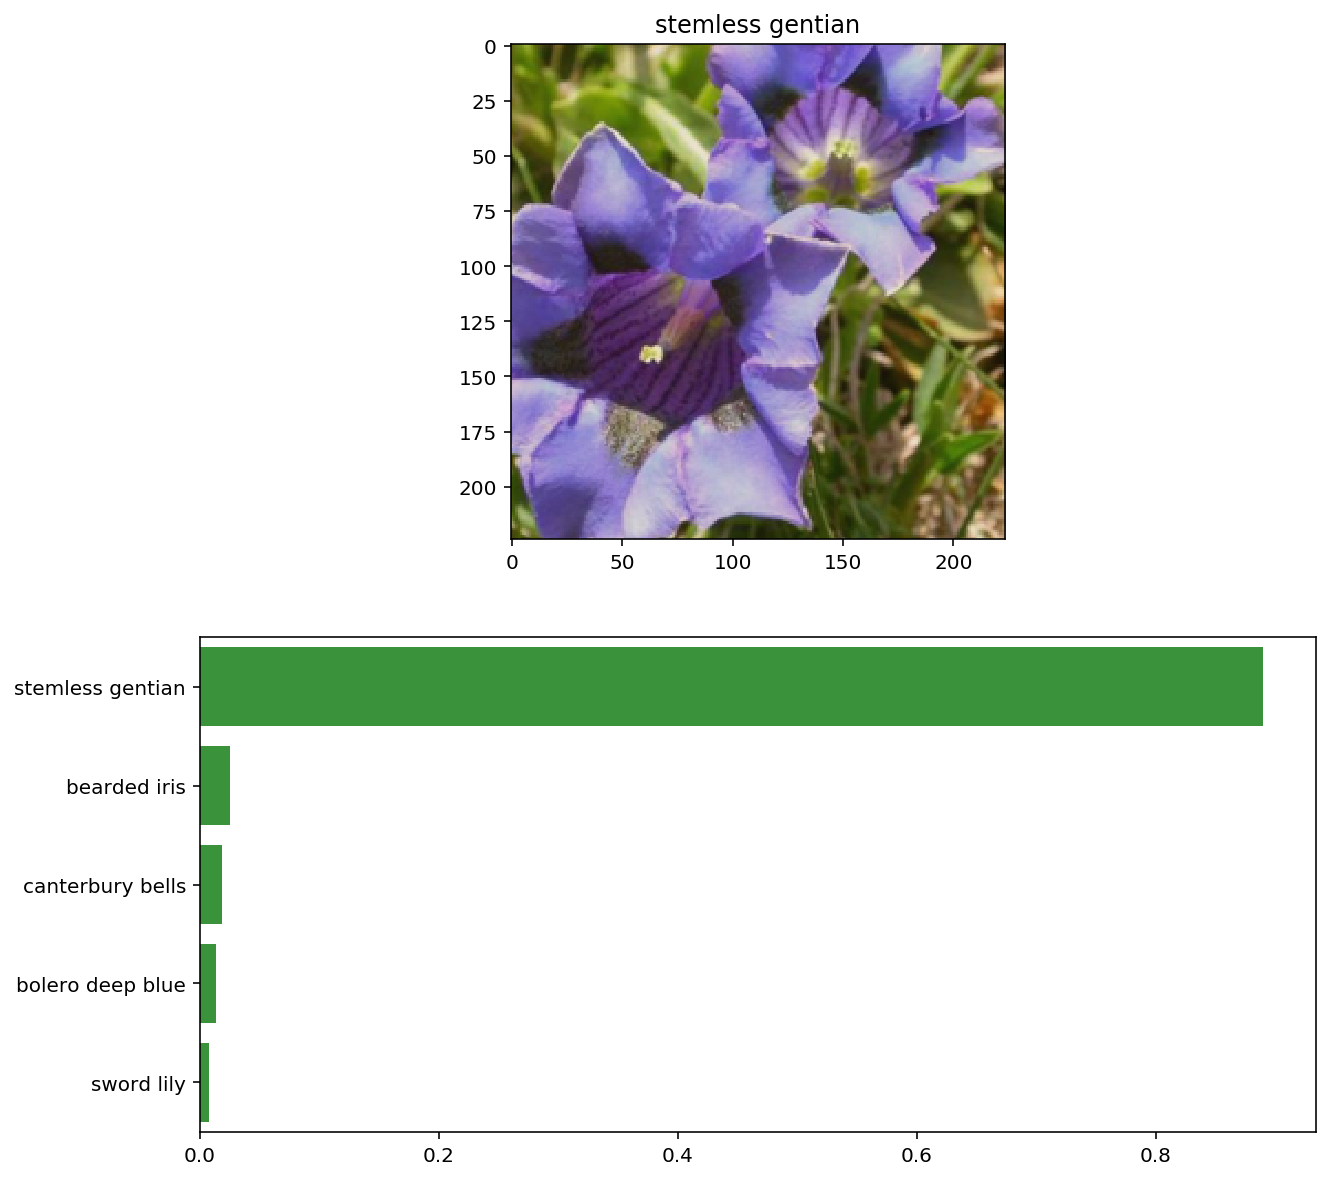

In [26]:
# TODO: Display an image along with the top 5 classes
save_dir = os.getcwd()
checkpointfile = save_dir +'/'+'final_checkpoint.pth'
loaded_model = load_checkpoint(checkpointfile)
loaded_model.eval()

image_path = 'flowers/test/28/image_05230.jpg'
top_probs, top_flowers = predict(image_path,loaded_model, topk=5)
plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)

import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)        
tensor_img = process_image(image_path)
img_label = cat_to_name[image_path.split('/')[2]]

imshow(tensor_img, ax, title = img_label)

import seaborn as sns
plt.subplot(2,1,2)
sns.barplot(x=top_probs, y=top_flowers, color = sns.color_palette()[2] )
plt.show()

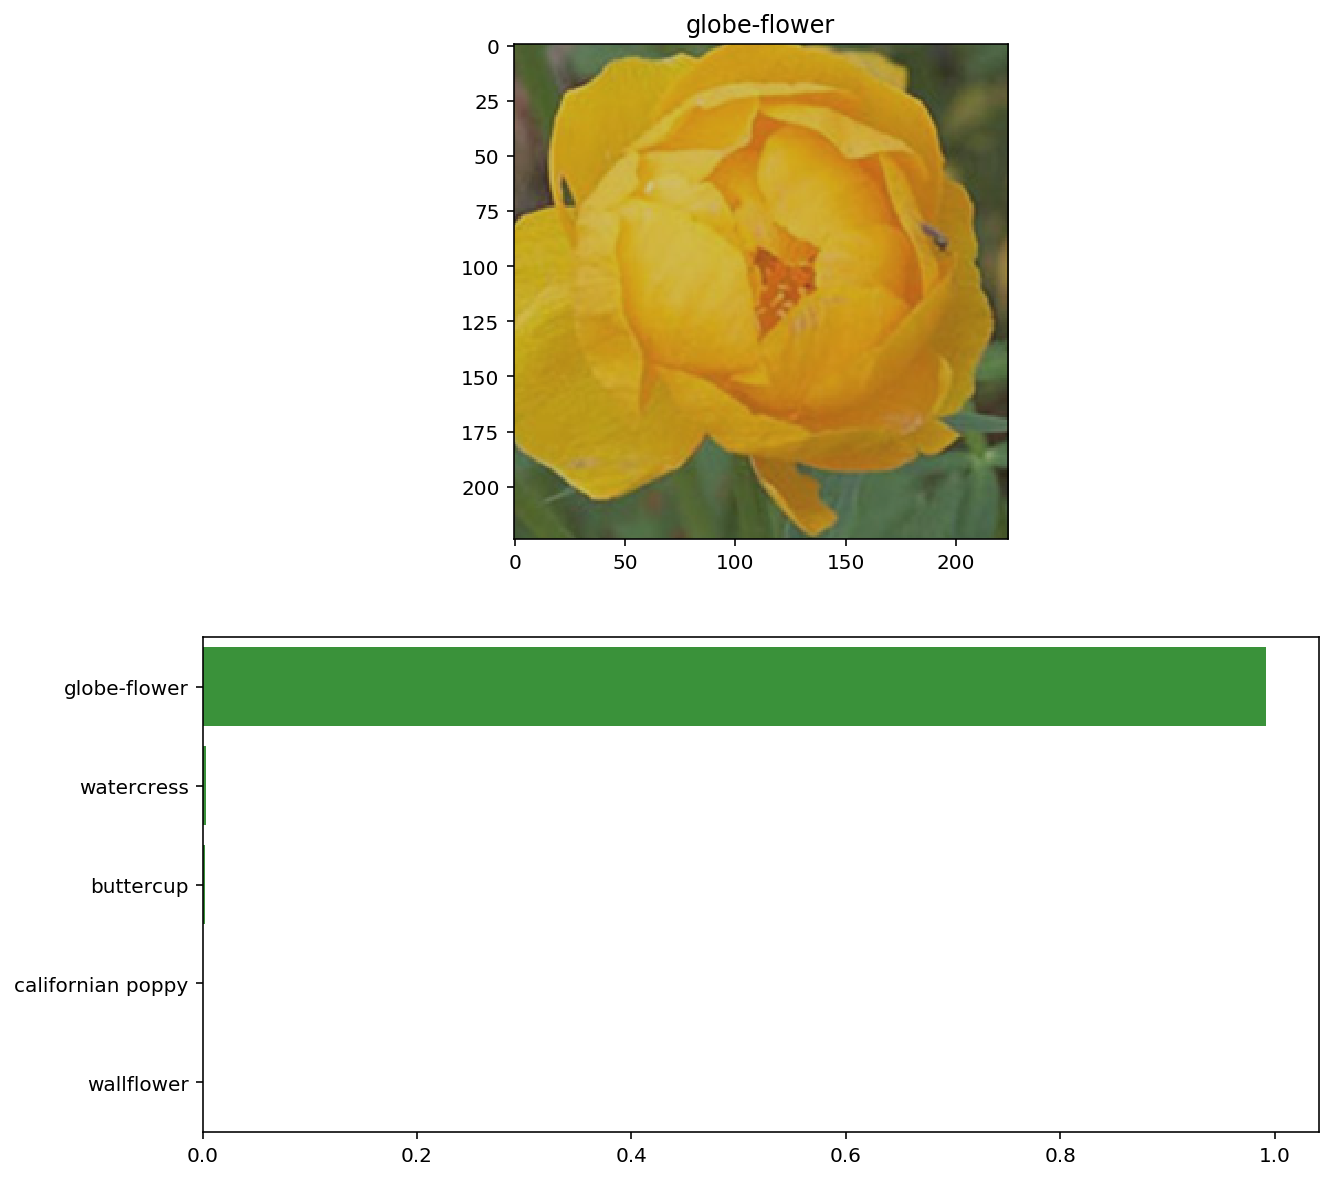

In [27]:
# TODO: Display an image along with the top 5 classes

image_path = 'flowers/test/16/image_06657.jpg'
top_probs, top_flowers = predict(image_path,loaded_model, topk=5)

plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)

import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)        
tensor_img = process_image(image_path)
img_label = cat_to_name[image_path.split('/')[2]]

imshow(tensor_img, ax, title = img_label)

import seaborn as sns
plt.subplot(2,1,2)
sns.barplot(x=top_probs, y=top_flowers, color = sns.color_palette()[2] )
plt.show()

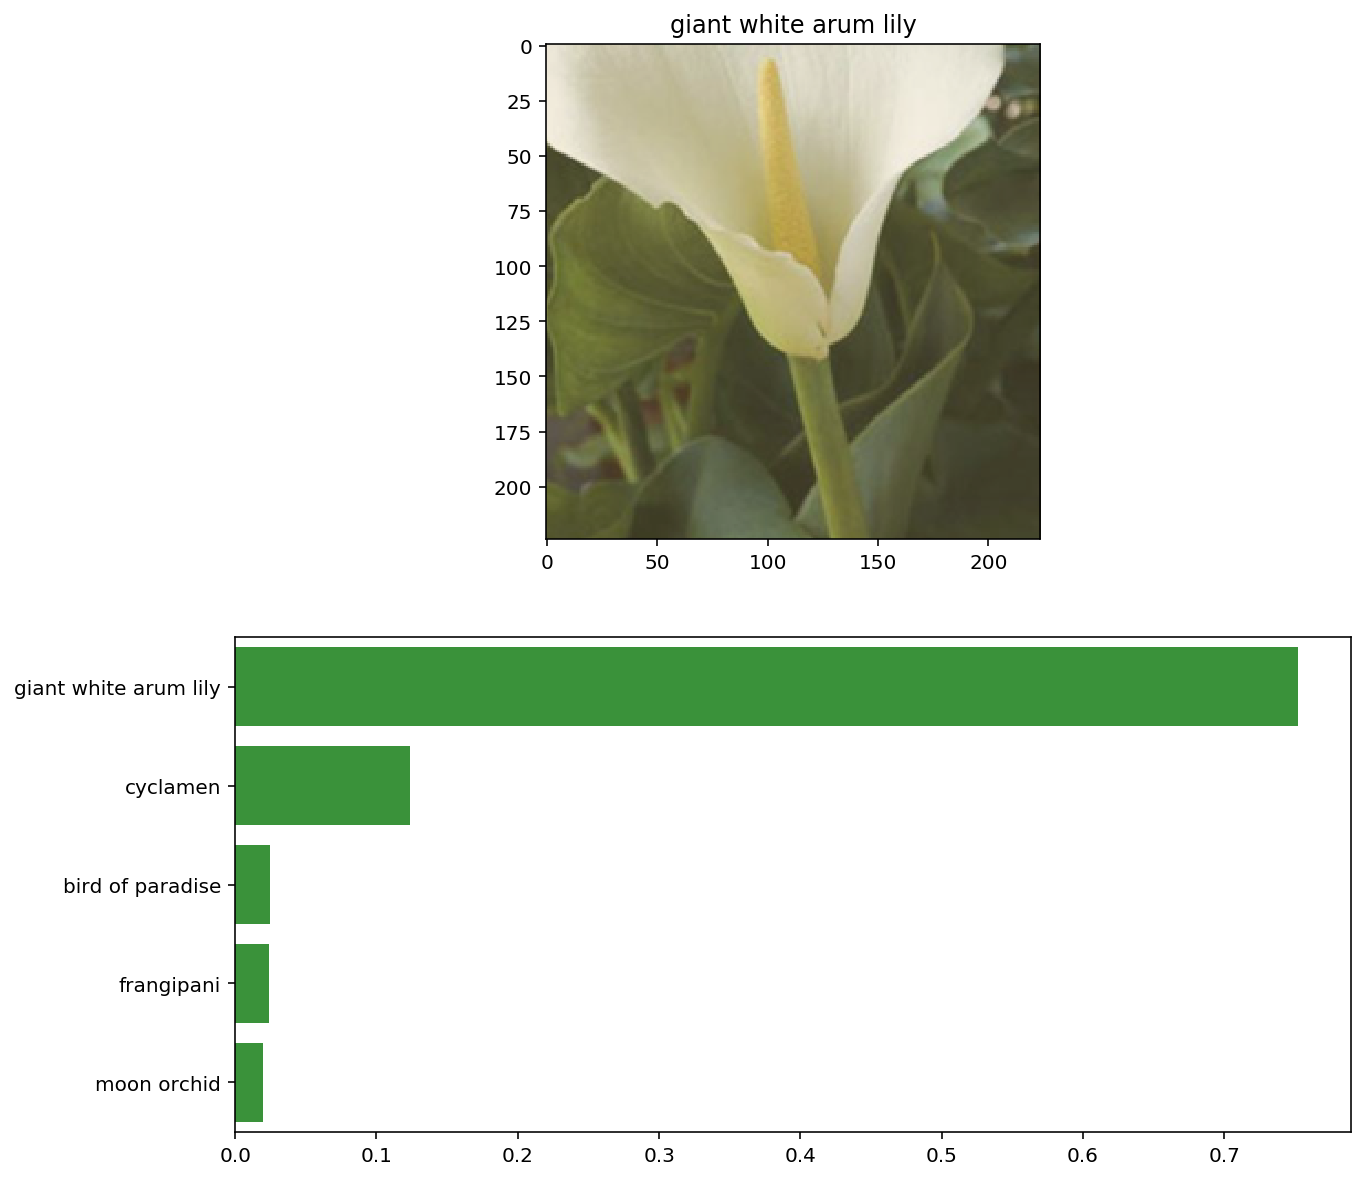

In [28]:
# TODO: Display an image along with the top 5 classes
image_path = 'flowers/test/20/image_04910.jpg'
top_probs, top_flowers = predict(image_path,loaded_model, topk=5)

plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)

import json
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)        
tensor_img = process_image(image_path)
img_label = cat_to_name[image_path.split('/')[2]]

imshow(tensor_img, ax, title = img_label)

import seaborn as sns
plt.subplot(2,1,2)
sns.barplot(x=top_probs, y=top_flowers, color = sns.color_palette()[2] )
plt.show()